In [83]:
import sys
sys.path.append('../')

import numpy as np
from scipy import ndimage

from skimage.filters import sobel_h
from skimage.filters import sobel_v
from scipy import stats


import os
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import scienceplots
from tensorflow.python.client import device_lib

plt.rcParams['figure.figsize'] = [10,10]

import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import decode_predictions
from tensorflow.keras.applications import VGG16, ResNet50, InceptionV3

from tensorflow.nn import depthwise_conv2d
from tensorflow.math import multiply, reduce_sum, reduce_mean,reduce_euclidean_norm, sin, cos, abs, reduce_variance, reduce_min, reduce_max
from tensorflow import stack, concat, expand_dims

import tensorflow_probability as tfp

from utils.utils import *
from utils.basic_units import *


plt.style.use(['science', 'ieee'])
plt.rcParams.update({'figure.dpi': '300'})

from mini_lucid_tf2 import objectives, transformations, render

#### Experiment #1 : $\beta$ accross all layers (Top-10% filters)

In [117]:
model = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(75, 75, 3))



In [104]:
conv_layers = []
for l in model.layers:
	if 'conv2d' in str(type(l)).lower():
		if l.kernel_size == (3,3):
			conv_layers.append(l)
conv_layers[2].name

'conv2d_2'

In [23]:
k = 10 # Top 10% highest l2-magnitude filters

Step 25


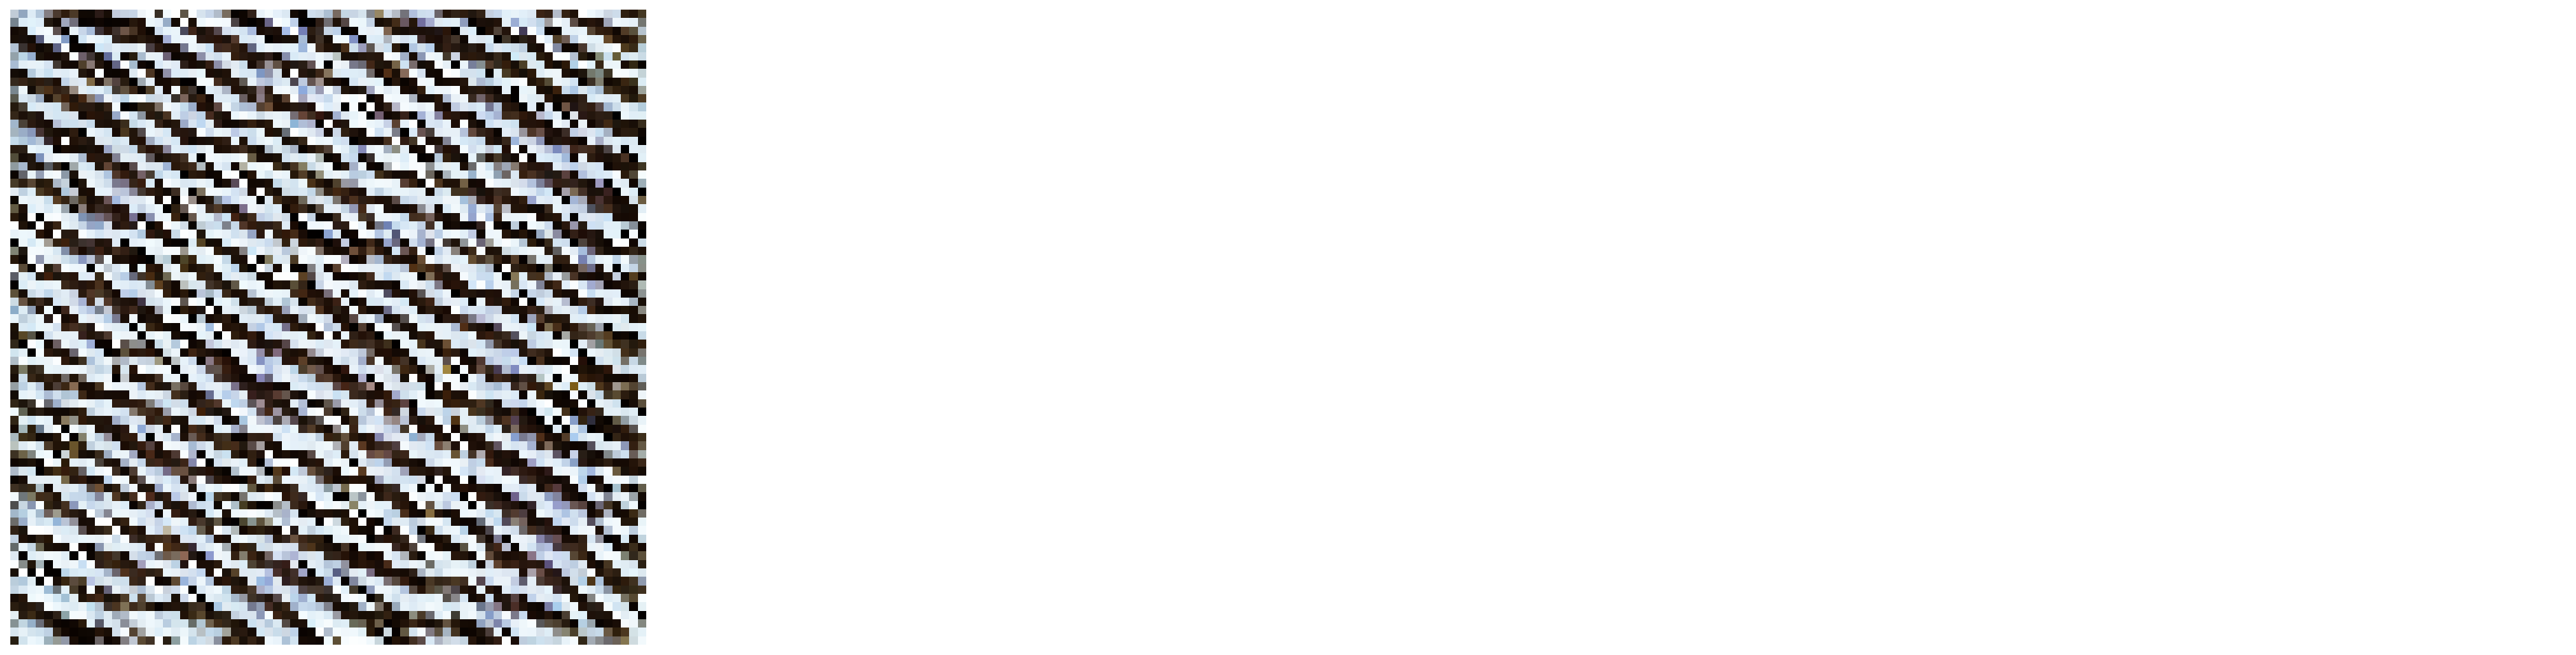

In [132]:
obj = objectives.Channel(model, 'block2_conv2', 19)
transforms = transformations.default_list

input_img = render.render_vis(obj, 75, transforms=transforms, steps=(25 ,), optimizer=tf.keras.optimizers.Adam(0.05), freq_decay=.1250, rgb_corr=True)

In [ ]:
conv_layers = []
for l in model.layers:
	if 'conv2d' in str(type(l)).lower():
		if l.kernel_size == (3,3):
			conv_layers.append(l)

In [80]:
model.fit(None, epochs=0)

RuntimeError: You must compile your model before training/testing. Use `model.compile(optimizer, loss)`.

FL (3, 3, 64, 64)
AMAG (64, 64)
(-3.141425609588623, 3.1395232677459717)
-3.141592653589793
['-$\\pi$', '0', '$\\pi$']


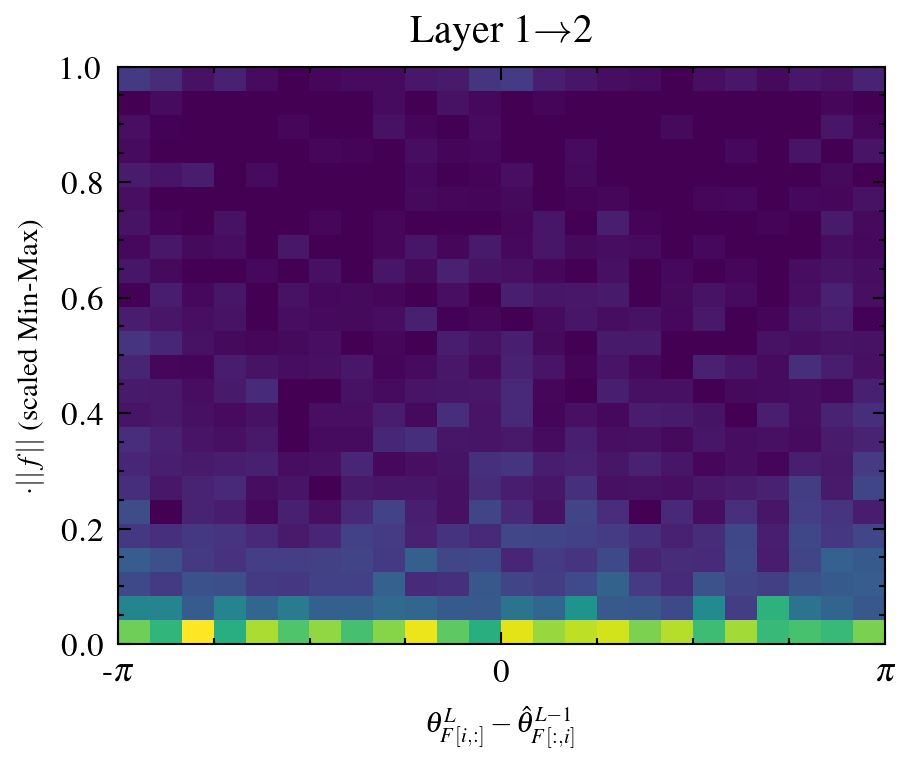

In [35]:


 
l_num = 1
#top10Fprev=topKfilters(model, l_num-1, k=20)
filtersLprev = get_filter(model, l_num-1)#[:,:,:,top10Fprev]
#top10F=topKfilters(model, l_num, k=20)
filtersL = get_filter(model, l_num)#[:,:,:,top10F]
filtersL = filtersL


print("FL", filtersL.shape)

# Get kernels magnitude and theta for layer L-1
sp, ap = getSymAntiSymTF(filtersLprev)
e_ap = reduce_euclidean_norm(ap, axis=[0,1])**2
e_sp = reduce_euclidean_norm(sp, axis=[0,1])**2
betap = e_ap/(e_ap+e_sp)


# Get kernels magnitude and theta for layer L
s, a = getSymAntiSymTF(filtersL)
e_a = reduce_euclidean_norm(a, axis=[0,1])**2
e_s = reduce_euclidean_norm(s, axis=[0,1])**2
dc = np.sign(np.mean(filtersL, axis=(0,1)))

beta = e_a/(e_a+e_s)



mag = reduce_euclidean_norm(filtersL, axis=[0,1])
a_mag = reduce_euclidean_norm(a, axis=[0,1]).numpy()
theta = getSobelTF(filtersL)
 
#mag = (e_a - reduce_min(e_a, axis=0, keepdims=True))/(reduce_max(e_a, axis=0, keepdims=True) - reduce_min(e_a, axis=0, keepdims=True))
mag = (a_mag - reduce_min(a_mag, axis=0, keepdims=True))/(reduce_max(a_mag, axis=0, keepdims=True) - reduce_min(a_mag, axis=0, keepdims=True))
print("AMAG", mag.shape)


#find lims :
cos_sim = []
m = []
weight = []
theta_F_prev = []
theta_F_prev = getDominantAngle(filtersLprev)
'''for i in range(filtersLprev.shape[-1]):
	theta_F_prev.append(get_F_angle(filtersLprev[:,:,:,i]))
theta_F_prev = np.array(theta_F_prev)'''
for i in range(filtersL.shape[-1]):
	#: = tf.where(tf.greater(dc[:, i],0))[:,0].numpy()
	mag = (a_mag[:,i]**2 - reduce_min(a_mag[:,i]**2 , axis=0, keepdims=True))/(reduce_max(a_mag[:,i]**2 , axis=0, keepdims=True) - reduce_min(a_mag[:,i]**2 , axis=0, keepdims=True))
	#print((theta_F_prev[:] - theta[:,i]).shape, mag.shape )
	cos_sim.extend(theta_F_prev - theta[:,i])#(np.cos(theta_F_prev - theta[i,:])))
	m.extend(mag.numpy())
	weight.extend(beta[:, i])
weight = np.array(weight)
m = np.array(m)




'''print("M", len(m))
m, t= rejection_sampling(m, cos_sim, 5000)
print(cos_sim)'''
#fig.subplots_adjust(left=None, bottom=None, right=0.005, top=0.005)

fig, ax= plt.subplots(1,1)

data = np.array(cos_sim)
data  = np.arctan2(np.sin(data), np.cos(data)) # (np.array(cos_sim) + np.pi) % (2 * np.pi) - np.pi
ax.hist2d(data,m, bins=24, weights=weight)
print(ax.get_xlim())
data_min, data_max = np.min(data), np.max(data)

# Set the tick marks at intervals of π
tick_min = np.floor(data_min / np.pi) * np.pi  # Start at the lowest multiple of π
tick_max = np.ceil(data_max / np.pi) * np.pi    # End at the highest multiple of π
ticks = np.arange(tick_min, tick_max + np.pi, np.pi)  # Ticks spaced by π
print(tick_min)
# Format tick labels with π notation
labels = [f"{int(t / np.pi)}π" if t != 0 else "0" for t in ticks]
labels = [label.replace("π", "$\\pi$").replace("1$\\pi$", "$\\pi$") for label in labels]
print(labels)
# Set ticks and labels on the x-axis
ax.set_xticks(ticks=ticks, labels=labels)




#ax.convert_xunits(radians)
ax.set_ylabel(r"$\cdot ||f||$ (scaled Min-Max)", fontsize=7)
#ax.set_ylabel(r"Count", fontsize=7)
ax.set_xlabel(r"$\mathbf{\theta}^{L}_{F[i, :]} - \hat{\theta}^{L-1}_{F[:, i]}$", fontsize=7)
ax.set_title(f"Layer {l_num}"+r"$\rightarrow$"+f"{l_num+1}")


plt.show() 


In [30]:
beta.shape

TensorShape([64, 128])

<BarContainer object of 16 artists>

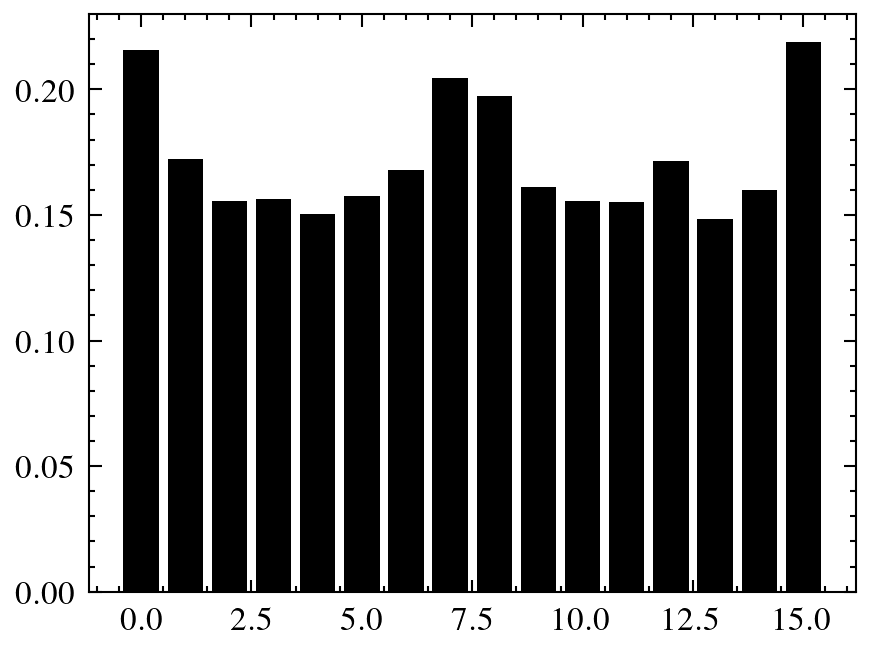

In [32]:

vals = ax.hist2d(data,m, bins=16, weights=m)
unweighted_vals = ax.hist2d(data,m, bins=16)

w_counts = vals[0]

uw_counts = unweighted_vals[0]

sum_intensities = tf.reduce_sum(w_counts, axis=1)/tf.reduce_sum(uw_counts, axis=1)
#plt.bar(sum_intensities, vals[1])
vals[1].shape
plt.bar(list(range(16)), sum_intensities)

(array([30.88288879, 24.00791168, 19.23190498, 11.27678585, 16.51103401,
         7.17255592,  8.24535942,  5.08909988,  7.78544235, 11.13573551,
         9.85868359, 12.12003136, 12.23280239, 15.27630234, 15.38050747,
        19.30548286, 24.90834427, 21.20318222, 13.1558466 , 14.34206772,
        16.0851059 ,  8.33265781,  9.39980507,  6.79962111,  9.87661457,
         6.46825552,  7.96671915,  8.80896664, 15.79207993, 21.41730881,
        18.28539276, 31.09416199]),
 array([-3.1414256e+00, -2.9452488e+00, -2.7490721e+00, -2.5528953e+00,
        -2.3567185e+00, -2.1605418e+00, -1.9643650e+00, -1.7681882e+00,
        -1.5720115e+00, -1.3758346e+00, -1.1796578e+00, -9.8348111e-01,
        -7.8730428e-01, -5.9112751e-01, -3.9495075e-01, -1.9877398e-01,
        -2.5972128e-03,  1.9357955e-01,  3.8975632e-01,  5.8593309e-01,
         7.8210986e-01,  9.7828668e-01,  1.1744634e+00,  1.3706402e+00,
         1.5668170e+00,  1.7629938e+00,  1.9591706e+00,  2.1553473e+00,
         2.3515241e+00

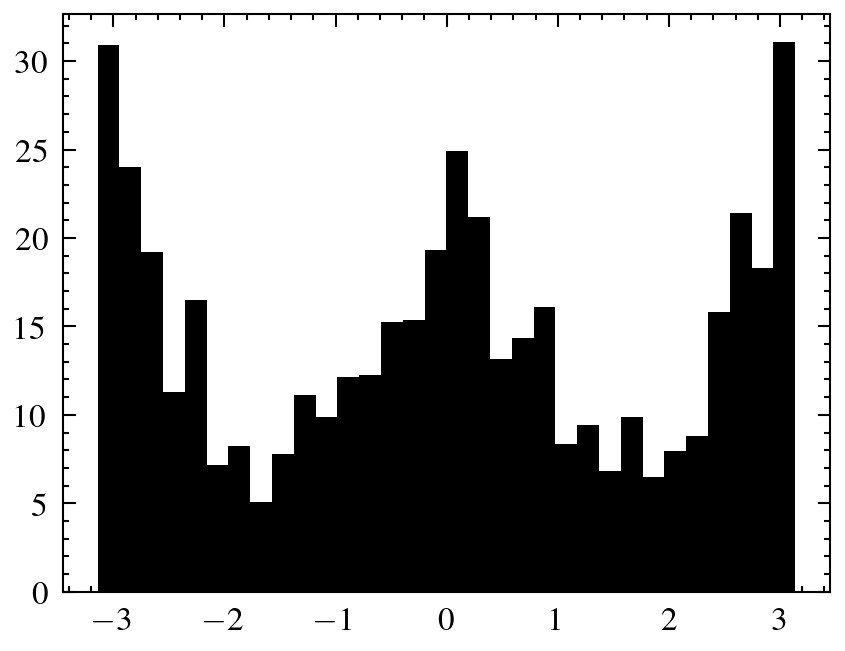

In [8]:
plt.hist(data, bins=32, weights=m)

(array([213., 169., 124.,  89., 107., 120., 140., 163., 185., 142., 113.,
        105., 104., 119., 167., 212.]),
 array([-3.1414256e+00, -2.7490721e+00, -2.3567185e+00, -1.9643650e+00,
        -1.5720115e+00, -1.1796578e+00, -7.8730428e-01, -3.9495075e-01,
        -2.5972128e-03,  3.8975632e-01,  7.8210986e-01,  1.1744634e+00,
         1.5668170e+00,  1.9591706e+00,  2.3515241e+00,  2.7438776e+00,
         3.1362312e+00], dtype=float32),
 <BarContainer object of 16 artists>)

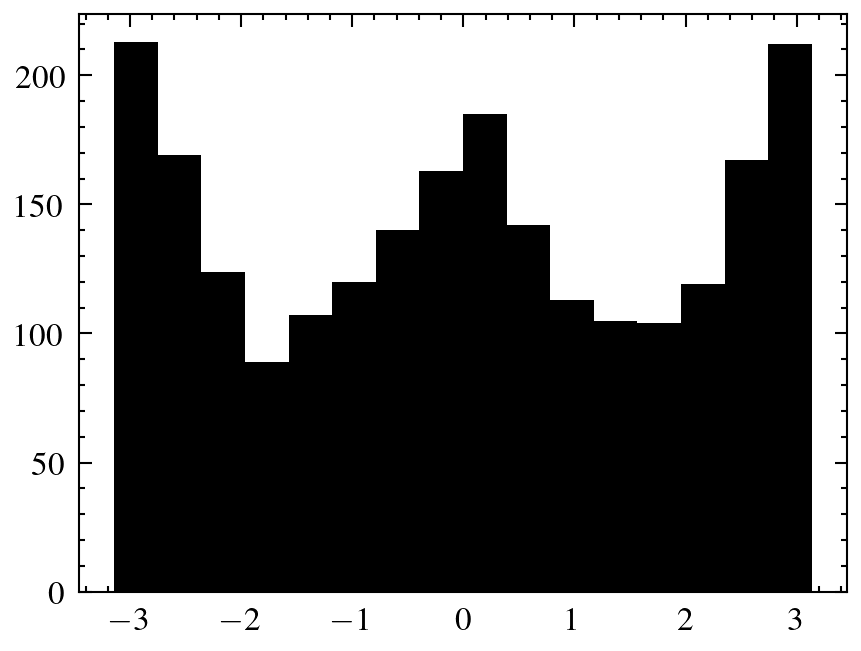

In [9]:
plt.hist(data, bins=16)

In [10]:
weight.shape

(2272,)

(array([54.89080048, 30.50868988, 23.68358994, 13.3344593 , 18.92117882,
        21.9787159 , 27.50910568, 34.68599319, 46.11152649, 27.49791336,
        24.41776466, 16.19942665, 16.34486961, 16.77568626, 37.20938873,
        49.37955475]),
 array([-3.1414256e+00, -2.7490721e+00, -2.3567185e+00, -1.9643650e+00,
        -1.5720115e+00, -1.1796578e+00, -7.8730428e-01, -3.9495075e-01,
        -2.5972128e-03,  3.8975632e-01,  7.8210986e-01,  1.1744634e+00,
         1.5668170e+00,  1.9591706e+00,  2.3515241e+00,  2.7438776e+00,
         3.1362312e+00], dtype=float32),
 <BarContainer object of 16 artists>)

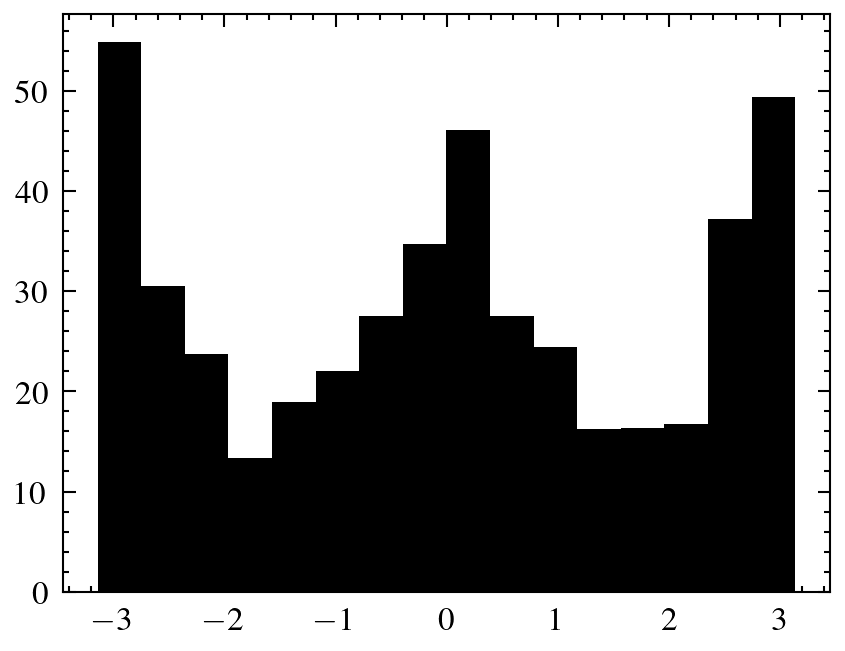

In [11]:
plt.hist(data, bins=16, weights=weight)